# Text Analytics: Kitchen Nightmare

# Section 1

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
classifier("I love this!")

In [ ]:
#file path
folder_path = 'E:/Google Drive/Text Analytics/data'

In [ ]:
####################   read transcripts   ####################
#Open the epizode
data_dict = {}
for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
      base_name = file_name.split('.')[0]
      file_path = os.path.join(folder_path, file_name)

      #Create dictionary with all epizodes
      with open(file_path, 'r') as file:
        data = file.read()
        data_dict[base_name] = data



    emotions_plotter = []
    fear_values = []
    anger_values = []
    trust_values = []
    surprise_values = []
    positive_values = []
    negative_values = []
    sadness_values = []
    disgust_values = []
    joy_values = []

    columns = ['file_name', 'sentence', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    df = pd.DataFrame(columns=columns)

#Loop through every epizode
for file_name, value in data_dict.items():
    sentence_list = value.split("\n\n")

    sentence_emotions = {}
    #Create Dictionary of sentences and values of their emotions for the epizode
    for text_row in sentence_list:
        emotion = classifier(text_row.lower())

        #Text aufteilen anders als pro Zeile oder aggregieren

        if text_row in sentence_emotions:
            # Find the number of occurrences of the sentence
            count = sum(1 for key in sentence_emotions.keys() if key.startswith(text_row))

            # Create a new entry for the duplicate sentence with a count
            text_row = f"{text_row} (Duplicate {count})"
            sentence_emotions[text_row] = emotion
        else:
            # If it doesn't exist, add a new entry for the sentence with its emotion values
            sentence_emotions[text_row] = emotion

        sentence = text_row
        anger = emotion[0][0]['score']
        disgust = emotion[0][1]['score']
        fear = emotion[0][2]['score']
        joy = emotion[0][3]['score']
        neutral = emotion[0][4]['score']
        sadness = emotion[0][5]['score']
        surprise = emotion[0][6]['score']

        #new DataFrame for the new row
        new_row = pd.DataFrame([[file_name, sentence, anger, disgust, fear, joy, neutral, sadness, surprise]], columns=columns)
        print(new_row)

        #Concatenate
        df = pd.concat([df, new_row], ignore_index=True)



In [ ]:
####################   create output   ####################
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
output_file = f'output_file_{timestamp}.xlsx'

# Export the DataFrame as a CSV file
df.to_csv(output_file, index=False)

In [ ]:
####################   Plot each emotion aggregate   ################
#Read file
df = pd.read_excel('classifier_output_file_2023-05-23_21-42-11.xlsx')

# Extract the emotions and their values
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
values = df[emotions].values

agg_value = 25

# Calculate the number of full groups of ten rows
num_groups = len(values) // agg_value

# Aggregate the full groups of ten rows and sum the values for each emotion
aggregated_values = np.sum(values[:num_groups * agg_value].reshape(num_groups, agg_value, len(emotions)), axis=1)

# Handle the remaining rows separately
remaining_rows = values[num_groups * agg_value:]
if len(remaining_rows) > 0:
    remaining_aggregated_values = np.sum(remaining_rows, axis=0, keepdims=True)
    aggregated_values = np.concatenate((aggregated_values, remaining_aggregated_values))

# Normalize the aggregated values
normalized_values = aggregated_values / np.sum(aggregated_values, axis=1, keepdims=True)

# Define the indices for the x-axis
indices = np.arange(len(normalized_values))

# Plotting the emotions as connected bars with aggregated and normalized values
fig, ax = plt.subplots(figsize=(10, 6))

width = 15 / len(emotions)
bottom = np.zeros(len(normalized_values))

for i, emotion in enumerate(emotions):
    ax.bar(indices, normalized_values[:, i], bottom=bottom, label=emotion, width=width, color=f"C{i}")
    bottom += normalized_values[:, i]

ax.set_xlabel('Index (Aggregated)')
ax.set_ylabel('Normalized Emotion Value')
ax.set_title('Emotion Analysis (Aggregated and Normalized)')
ax.legend(loc='upper right')

plt.show()


# Generate separate line plots for each emotion
for i, emotion in enumerate(emotions):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(indices, normalized_values[:, i], label=emotion, color=f"C{i}")
    ax.set_xlabel('Index (Aggregated)')
    ax.set_ylabel('Normalized Emotion Value')
    ax.set_title(f'Emotion Analysis: {emotion}')
    ax.legend(loc='upper right')

    plt.show()

In [ ]:
####################   Plot each emotion for each epizode   ################
# Read the Excel file and create a DataFrame
df = pd.read_excel('classifier_output_file_2023-05-23_21-42-11.xlsx')

# Group the DataFrame by 'file_name'
grouped = df.groupby('file_name')

# Create a dictionary to store the variables
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
epizodes = {}

# Iterate over each group and create a variable for each file_name
for file_name, group in grouped:
    # Create a variable name using the file_name
    variable_name = file_name.replace('.txt', '')  # You can modify this to suit your naming preference

    # Assign the group data to the variable
    epizodes[variable_name] = group



#EMOTION PLOT
for emotion in emotions:
    fig, ax = plt.subplots()

    # Iterate over each episode
    for episode_name, episode_data in epizodes.items():
        # Group the 'anger' series by custom grouping logic (aggregate every 10 rows)
        grouped_data = episode_data.groupby(np.arange(len(episode_data)) // 10)[emotion].mean()
        # Plot the grouped data
        #plt.fill_between(grouped_data.index[:123], grouped_data[:123])
        ax.plot(grouped_data.index[:123], grouped_data[:123], label=episode_name)  # Plot the first 123 aggregated rows




    # Adding labels and title
    ax.set_xlabel('Index')
    ax.set_ylabel('Average')
    ax.set_title(emotion)

    plt.show()

####################   Create heatmap   ################
#DataFrame to store the aggregated mean values for each emotion
aggregated_data = pd.DataFrame()

#20 bins; calculate the mean of each emotion within each bin
for episode_name, episode_data in df.groupby('file_name'):
    num_bins = 20
    bin_size = len(episode_data) / num_bins
    episode_bins = episode_data.groupby(np.arange(len(episode_data)) // bin_size).mean()
    aggregated_data = aggregated_data.append(episode_bins)

desired_sequence = ['joy', 'surprise', 'sadness', 'disgust', 'anger', 'fear']
aggregated_data = aggregated_data[desired_sequence]

aggregated_data = aggregated_data.groupby(aggregated_data.index).sum()

#Create the heatmap plot
fig, ax = plt.subplots()
cmap = 'Reds'

im = ax.imshow(aggregated_data.T, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(aggregated_data)))
ax.set_yticks(np.arange(len(aggregated_data.columns)))
ax.set_xticklabels(np.arange(len(aggregated_data)))
ax.set_yticklabels(aggregated_data.columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#labels and title
ax.set_xlabel('Bin Number')
ax.set_ylabel('Emotion')
ax.set_title('Season 1')

plt.show()

In [ ]:
####################   chat GPT Ticker  ################

pip install openai
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import openai
import time
import datetime
import pytz

tz = pytz.timezone('Europe/Berlin')

from google.colab import drive
drive.mount("/content/drive")

folder_path = "/content/drive/MyDrive/Openai/data"
folder_path_data = "/content/drive/MyDrive/Openai/data/one"


api_key = pd.read_csv("/content/drive/MyDrive/Openai/api_key.txt")
api_key = api_key.columns[0]
openai.api_key = api_key

def ChatGPT(sentence, prompt, emotion_list_1, emotion_list_2, model):
  prompt = prompt.format(emotion_list_1,emotion_list_2, sentence)
  output = openai.ChatCompletion.create(
      model=model,
      messages=[
          {"role": "system", "content": "You are a helpful assistant."},
          {"role": "user", "content": prompt}],
          max_tokens=200,
          temperature=0)
  output = output.choices[0].message.content
  output = eval(output)
  return output

def try_ChatGPT(sentence, prompt, emotion_list_1, emotion_list_2, model, num_retries=10, retry_interval=5):
    for _ in range(num_retries):
        try:
            return ChatGPT(sentence, prompt, emotion_list_1, emotion_list_2, model)
        except Exception as e:
            print("Retrying...")
            sentence = sentence[:-1]
            time.sleep(retry_interval)

    raise Exception("Maximum number of retries exceeded.")

def GPT3(sentence, prompt, emotion_list, model):
  emotion_list = emotion_list,
  prompt = prompt.format(emotion_list, sentence),
  output = openai.Completion.create(
    engine=model,
    prompt=prompt,
    max_tokens=200,
    temperature=0)
  output = eval(output['choices'][0]['text'])
  return output

prompt = "In welche Emotionen {0} und mit welchem Score würdest du diesen Text: ({2}) klassifizieren? Die Summe aller Scores muss immer 1 betragen (X0 + X1 + X2 + X3 + X4 + X5 = 1)! Bitte gib das Resultat ohne eine Beschreibung in folgendem Format zurück {1}"
emotion_list_1 = "'anger', 'surprise', 'sadness', 'disgust', 'joy', 'neutral'"
emotion_list_2 = "[('anger', X0), ('surprise', X1), ('sadness', X2), ('disgust', X3), ('joy', X4), ('neutral', X5)]"
model = "gpt-3.5-turbo"

print("Start: ", datetime.datetime.now(tz))

#read files


#Open the epizode
data_dict = {}
for file_name in os.listdir(folder_path_data):
    if file_name.endswith(".txt"):
      base_name = file_name.split('.')[0]
      file_path = os.path.join(folder_path_data, file_name)

      #Create dictionary with all epizodes
      with open(file_path, 'r') as file:
        data = file.read()
        data_dict[base_name] = data

columns = ['file_name', 'sentence', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df = pd.DataFrame(columns=columns)

#Loop through every epizode
for file_name, value in data_dict.items():
    sentence_list = value.split("\n\n")
    print(file_name)
    print(len(sentence_list))
    i = 1089
    print("")


    sentence_emotions = {}
    #Create Dictionary of sentences and values of their emotions for the epizode
    for text_row in sentence_list[i:]:
        #emotion = NRCLex(text_row.lower()).top_emotions
        if text_row == "":
          text_row = "neutral"
        emotion = try_ChatGPT(text_row, prompt, emotion_list_1, emotion_list_2, model)

        anger = 0
        disgust = 0
        fear = 0
        joy = 0
        neutral = 0
        sadness = 0
        surprise = 0

        for emo in emotion:
          if emo[0] == "anger":
            anger = emo[1]
          elif emo[0] == "disgust":
            disgust = emo[1]
          elif emo[0] == "fear":
            fear = emo[1]
          elif emo[0] == "joy":
            joy = emo[1]
          elif emo[0] == "neutral":
            neutral = emo[1]
          elif emo[0] == "sadness":
            sadness = emo[1]
          elif emo[0] == "surprise":
            surprise = emo[1]

        # Create a new DataFrame for the new row
        new_row = pd.DataFrame([[file_name, text_row, anger, disgust, fear, joy, neutral, sadness, surprise]], columns=columns)
        new_row.to_csv(folder_path + "/output/output_file_{1}_{0}_16_06_23.csv".format(str(i).zfill(6), file_name))
        print(i, text_row[0:5], emotion)
        i = i + 1

df = pd.DataFrame()
for i in range(len(os.listdir(folder_path  + "/output"))):
  df_pre = pd.read_csv(folder_path + "/output/output_file_steven_{0}_06_06_23.csv".format(i))
  df = pd.concat([df, df_pre])

df = df.drop('Unnamed: 0', axis=1)
df = df.reset_index()
df = df.drop('index', axis=1)
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
file_name = df["file_name"].iloc[0]

df.to_excel(folder_path + "/chatgpt_output_{0}_{1}.xlsx".format(file_name, timestamp))
df




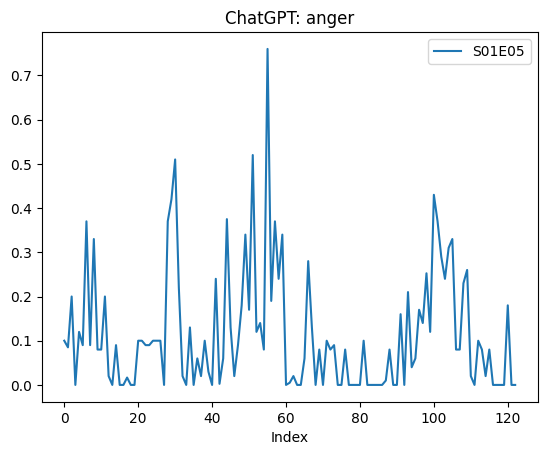

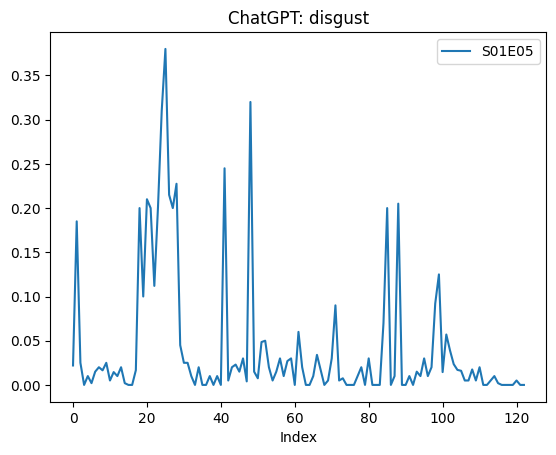

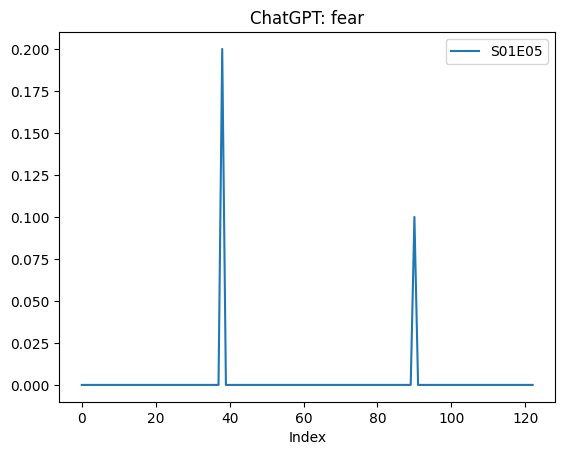

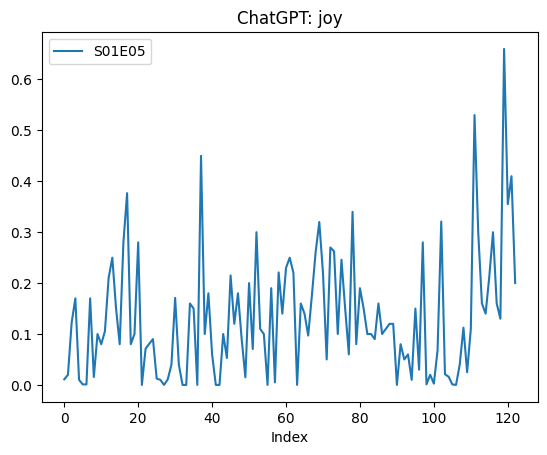

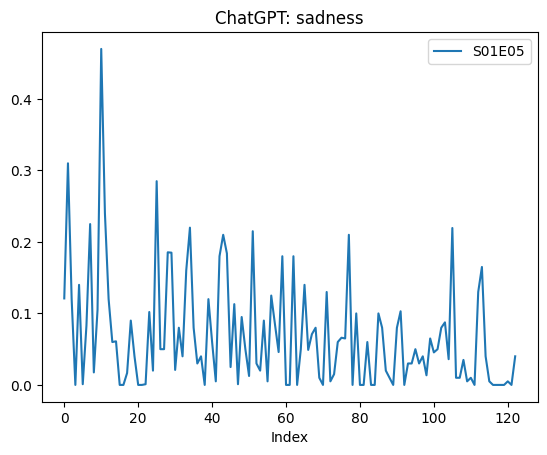

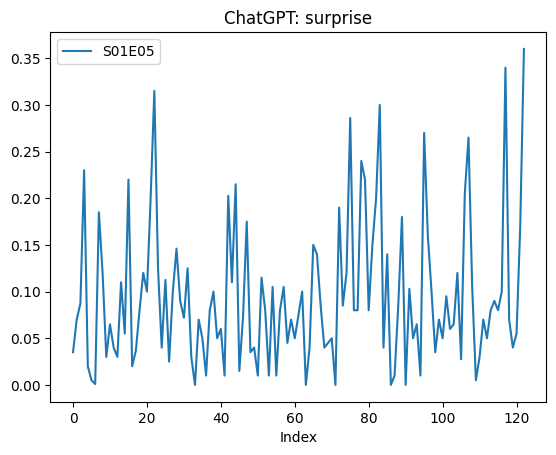

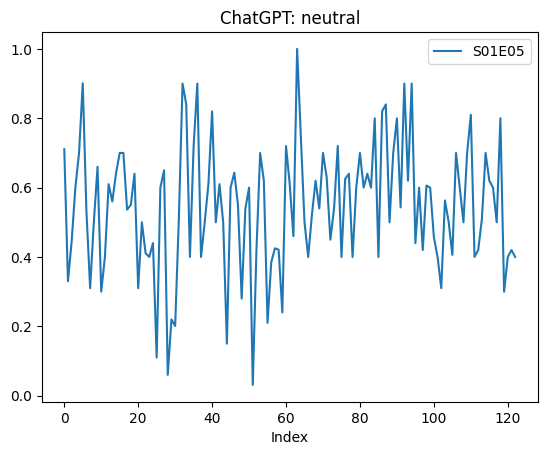

In [ ]:
##########  Chat GPT Plotter   ##########
df = pd.read_excel(folder_path + '/chatgpt_output_S01E05_2023-06-06_14-37-01.xlsx').drop('Unnamed: 0', axis=1)

# Group the DataFrame by 'file_name'
grouped = df.groupby('file_name')

# Create a dictionary to store the variables
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
epizodes = {}

# Iterate over each group and create a variable for each file_name
for file_name, group in grouped:
    # Create a variable name using the file_name
    variable_name = file_name.replace('.txt', '')  # You can modify this to suit your naming preference

    # Assign the group data to the variable
    epizodes[variable_name] = group


#PLOT

for emotion in emotions:
    fig, ax = plt.subplots()

    # Iterate over each episode
    for episode_name, episode_data in epizodes.items():
        # Group the 'anger' series by custom grouping logic (aggregate every 10 rows)
        grouped_data = episode_data.groupby(np.arange(len(episode_data)) // 10)[emotion].mean()

        # Plot the grouped data
        ax.plot(grouped_data.index[:123], grouped_data[:123], label=episode_name)  # Plot the first 123 aggregated rows

    # Adding labels and title
    ax.set_xlabel('Index')
    ax.set_ylabel('')
    ax.set_title("ChatGPT: " + emotion)

    # Adding a legend
    ax.legend()

    # Displaying the plot
    plt.show()

In [ ]:
####################   heatmaps with threshold approach for 3 files  ################
#df = pd.read_excel('classifier_output_file_2023-05-23_21-42-11.xlsx')
#df = pd.read_excel('chatgpt_output_S01E05.xlsx')
df = pd.read_excel('classifier_output_S01E05.xlsx')

#Group the DataFrame by 'file_name'
grouped = df.groupby('file_name')

#Create a dictionary to store the variables
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
epizodes = {}

#Iterate over each group and create a variable for each file_name
for file_name, group in grouped:
    var_file = file_name.replace('.txt', '')
    epizodes[var_file] = group

#empty DataFrame to store the aggregated counts for each emotion
aggregated_data = pd.DataFrame()

### Threshold
threshold = 0.3

#20 bins; count the number of sentences with emotions above the threshold
for episode_name, episode_data in df.groupby('file_name'):
    num_bins = 20
    bin_size = len(episode_data) // num_bins
    episode_bins = []
    for bin_idx in range(num_bins):
        bin_start = bin_idx * bin_size
        bin_end = (bin_idx + 1) * bin_size
        bin_counts = {'Episode': episode_name}
        for emotion in ['joy', 'surprise', 'sadness', 'disgust', 'anger', 'fear']:
            emotion_count = (episode_data[emotion][bin_start:bin_end] > threshold).sum()
            bin_counts[emotion] = emotion_count

        episode_bins.append(bin_counts)
    episode_bins_df = pd.DataFrame(episode_bins)
    aggregated_data = aggregated_data.append(episode_bins_df)

aggregated_data_unsep = aggregated_data
aggregated_data = aggregated_data.groupby(aggregated_data.index).sum()


#Reorder the columns
desired_sequence = ['joy', 'surprise', 'sadness', 'disgust', 'anger', 'fear']
aggregated_data = aggregated_data[desired_sequence]

#Get the emotion names from the column names
emotions = aggregated_data_unsep.columns


####################   Create heatmap   ################
fig, ax = plt.subplots()
cmap = 'Reds'

im = ax.imshow(aggregated_data.T, cmap=cmap)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(aggregated_data)))
ax.set_yticks(np.arange(len(aggregated_data.columns)))
ax.set_xticklabels(np.arange(len(aggregated_data)))
ax.set_yticklabels(aggregated_data.columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#labels and title
ax.set_xlabel('Bin Number')
ax.set_ylabel('Emotion')
ax.set_title('S01E05 BERT Threshold ' + str(threshold))

plt.show()

and text here